In [ ]:
!nvidia-smi

Sat Mar  2 19:47:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Question 1
Implement and train your RNN language model on Wikitext-2 corpus using the
guidelines specified above.

a. provide a description (or illustration) of you architecture and discuss design choices,

b. list hyper-parameters used by you model and discuss how you selected these values,

c. provide learning curves of perplexity vs. epoch on the training and validation sets, and

d. provide final test set perplexity.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import itertools
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Fix a seed for reproducibility
seed_value = 42
# PyTorch RNGs
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)

## Architecture and design
### Network
**Embedding Input**
Transforms token indices into embeddings, preparing them for sequence processing.

**RNN Processing**
Processes the embedded sequence through the RNN, updating the hidden state at each timestep.

**Output Handling**
Initially, the outputs for the last timestep of each sequence are extracted using x[:, -1, :], indicating the model's prediction is based on the entire preceding sequence.
The outputs are then reshaped for the fully connected layer to make token predictions.

**Token Prediction**
Passes the last timestep's features through the fully connected layer to predict the next token.

## Design


In [ ]:
class RNNModel(nn.Module):
    def __init__(self, params):
        super(RNNModel, self).__init__()
        self.params = params

        self.train_loader, self.valid_loader, self.test_loader, self.token_to_id = load_data(self.params)
        print (len(self.train_loader), len(self.valid_loader), len(self.test_loader))

        self.embedding = nn.Embedding(len(self.token_to_id), self.params['embedding_dim'])  # random initialize
        self.h = self._init_hidden(self.params['batch_size'])
        self.rnn = nn.RNN(self.params['embedding_dim'], self.params['hidden_dim'], self.params['num_rnn_layer'], dropout=self.params['dropout'], batch_first=True)
        self.fc = nn.Linear(self.params['hidden_dim'], len(self.token_to_id))

        self.criterion = nn.CrossEntropyLoss()
        if self.params['weight_decay']:
          self.optimizer = optim.Adam(self.parameters(), lr=self.params['learning_rate'], weight_decay=self.params['weight_decay'])
        else:
          self.optimizer = optim.Adam(self.parameters(), lr=self.params['learning_rate'])

    def _init_hidden(self, batch_size):
        return torch.zeros(self.params['num_rnn_layer'], batch_size, self.params['hidden_dim']).to(device)

    def forward(self, x, hidden):
        x = self.embedding(x)  # The embedding layer translates these indices into dense vectors of fixed size (the embedding size).
        x, hidden = self.rnn(x, hidden)
        x = x[:, -1, :]   # Select only the outputs from the last timestep of each sequence; we do not need this sentence if we predict the next token at each time step.
        x = x.contiguous().view(-1, self.params['hidden_dim'])  # Reshape output for the fully connected layer
        out = self.fc(x)
        return out, hidden

    def train(self):
        train_losses = []
        validation_losses = []
        train_perplexities = []
        validation_perplexities = []

        for epoch in range(self.params['epoch']):
            # Train
            train_loss = 0
            for id, (inputs, labels) in enumerate(self.train_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                self.optimizer.zero_grad()
                if self.params['training_shuffle']:
                    hidden = self._init_hidden(inputs.size(0))
                else:
                    hidden = self.h
                outputs, self.h = self.forward(inputs, hidden)
                self.h = self.h.detach().to(device)
                loss = self.criterion(outputs, labels.view(-1))
                loss.backward()
                if self.params['clip_value']:
                  torch.nn.utils.clip_grad_norm_(self.parameters(), self.params['clip_value'])
                self.optimizer.step()
                train_loss += loss.item()
            train_loss /= len(self.train_loader)
            train_losses.append(train_loss)
            train_perplexity = torch.exp(torch.tensor(train_loss)).item()
            train_perplexities.append(train_perplexity)
            print (f'Epoch {epoch + 1}/{self.params["epoch"]}, Train Loss: {train_loss:.4f}, Train Perplexity: {train_perplexity:.4f}')

            # Validation
            validation_loss = 0
            with torch.no_grad():
                for id, (inputs, labels) in enumerate(self.valid_loader):
                    inputs, labels = inputs.to(device), labels.to(device)
                    hidden = self._init_hidden(inputs.size(0))
                    outputs, _ = self.forward(inputs, hidden)
                    loss = self.criterion(outputs, labels.view(-1))
                    validation_loss += loss.item()
            validation_loss /= len(self.valid_loader)
            validation_losses.append(validation_loss)
            validation_perplexity = torch.exp(torch.tensor(validation_loss)).item()
            validation_perplexities.append(validation_perplexity)
            print (f'Epoch {epoch + 1}/{self.params["epoch"]}, Validation Loss: {validation_loss:.4f}, Validation Perplexity: {validation_perplexity:.4f}')

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        # Plotting Training and Validation Loss on the first subplot
        ax1.plot(train_losses, label='Training Loss', color='blue')
        ax1.plot(validation_losses, label='Validation Loss', color='red')
        ax1.set_title('Training and Validation Loss', fontsize=16)
        ax1.set_xlabel('Epochs', fontsize=14)
        ax1.set_ylabel('Loss', fontsize=14)
        ax1.legend()
        # Plotting Training and Validation Perplexity on the second subplot
        ax2.plot(train_perplexities, label='Training Perplexity', color='green')
        ax2.plot(validation_perplexities, label='Validation Perplexity', color='purple')
        ax2.set_title('Training and Validation Perplexity', fontsize=16)
        ax2.set_xlabel('Epochs', fontsize=14)
        ax2.set_ylabel('Perplexity', fontsize=14)
        ax2.legend()
        # Display the plots
        plt.tight_layout()
        # fig_name = '_'.join([str(item) for item in self.params.values()]) + '.jpg'
        # plt.savefig(fig_name, dpi=300, bbox_inches='tight')
        plt.show()

    def test(self):
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                hidden = self._init_hidden(inputs.size(0))
                outputs, _ = self.forward(inputs, hidden)
                loss = self.criterion(outputs, labels.view(-1))
                total_loss += loss.item()
        avg_loss = total_loss / len(self.test_loader)
        perplexity = torch.exp(torch.tensor(avg_loss))
        print(f'Test Perplexity: {perplexity.item():.3f}')
        return avg_loss, perplexity

In [ ]:
def replace_unk(original_dict, word_freq_threshold):
    new_dict = {}
    sum_values = 0
    words_replaced_w_unk = []
    for key, value in original_dict.items():
        if value < word_freq_threshold and key != '<unk>':
            sum_values += value
            words_replaced_w_unk.append(key)
        else:
            new_dict[key] = value
    if sum_values > 0:
        new_dict['<unk>'] = new_dict['<unk>'] + sum_values
    return new_dict, words_replaced_w_unk

In [ ]:
def read_train_data(file_name):
    # Read files
    with open(file_name, 'r') as file:
        content = file.read()
    # Split text
    words = content.lower().split(' ')
    # Count the text frequency
    word_freq = Counter(words)
    # Replace keys with small frequencies with <unk>
    new_word_freq, words_replaced_w_unk = replace_unk(word_freq, 15)
    # Convert tokens to id
    token_to_id = {"<unk>": 0}
    token_to_id.update({word: idx for idx, word in enumerate(set([word for word in new_word_freq if word != '<unk>']), start=1)})
    # Convert corpus to id sequences
    sequences = [token_to_id.get(word, token_to_id["<unk>"]) for word in words]
    return sequences, token_to_id

In [ ]:
def read_valid_test_data(file_name, token_to_id):
    # Read files
    with open(file_name, 'r') as file:
        content = file.read()
    # Split text
    words = content.lower().split(' ')
    # Convert corpus to id sequences
    sequences = [token_to_id.get(word, token_to_id["<unk>"]) for word in words]
    return sequences

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, text, params):
        self.data = [text[i:i + params['time_step']] for i in range(0, len(text) - params['time_step'])]
        # self.labels = [text[i + 1:i + 1 + params['time_step']] for i in range(0, len(text) - params['time_step'])]. # Predict the next token at each time step
        self.labels = [text[i + params['time_step']] for i in range(0, len(text) - params['time_step'])]  # Predict the next token after a sequence

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

In [ ]:
def load_data(params):
    # Read data into id sequences
    train_data, token_to_id = read_train_data('wiki2.train.txt')
    valid_data = read_valid_test_data('wiki2.valid.txt', token_to_id)
    test_data = read_valid_test_data('wiki2.test.txt', token_to_id)

    # Create dataset instances
    train_dataset = CustomDataset(train_data, params)
    valid_dataset = CustomDataset(valid_data, params)
    test_dataset = CustomDataset(test_data, params)

    # Load dataset
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=params['training_shuffle'], num_workers=12, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=12, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=12, pin_memory=True)
    return train_loader, valid_loader, test_loader, token_to_id

## Hyper parameter

### Fixed parameters

**batch_size**: 1024

A trade-off between training speed and training resources, we pick 1024 as batch_size.

**epoch**: 20

It is required we train 20 epochs.

**num_rnn_layer**: 1

For question 1, we start with 1 rnn layer and will experiment with 2 or more layers in question 2.

**dropout**: 0,

Dropout is designed to prevent overfitting between the different layers of the network. It should only be applied when there are multiple layers (num_layers > 1) because it's meant to act between these layers. If we only have one layer (num_layers=1), there's nowhere for the dropout to be applied in the way it's intended in these models.

**weight_decay**: False

For question 1, we do not add weight decay for now as we do not know whether the language model is prone to overfitting yet. We will experiment with weight deday in question 2.

**clip_value**: False

For question 1, we do not add gradient clipping for now as we have not observed vanishing or exploding gradient yet. We will experiment with gradient clipping in question 2.


### More experiments

**time_step**: baseline: 10, experiment: (10, 20, 30)

**embedding_dim**: baseline: 100, experiment: (100, 300)

**hidden_dim**: baseline: 100, experiment: (100, 200, 500)

**learning_rate**: baseline: 0.001, experiment: (0.001, 0.01)

**training_shuffle**: baseline: True, experiment: (True, False)

Since we have limited computing resources, we will not run grid_search. Instead, we will compare paramters separately.

In [ ]:
def grid_search():
    params = {
        'batch_size': None,
        'time_step': None,
        'embedding_dim': None,
        'hidden_dim': None,
        'num_rnn_layer': None,
        'dropout': None,
        'epoch': None,
        'learning_rate': None,
        'training_shuffle': None,
        'weight_decay': None,
        'clip_value': None,}
    batch_size = [1024]
    time_step = [10, 20, 30]
    embedding_dim = [100, 300]
    hidden_dim = [100, 200, 500]
    num_rnn_layer = [1]
    dropout = [0]
    epoch = [20]
    learning_rate = [0.0001, 0.001]
    training_shuffle = [True, False]
    weight_decay = [False]
    clip_value = [False]
    param_combinations = list(itertools.product(batch_size, time_step, embedding_dim, hidden_dim, num_rnn_layer, dropout, epoch, learning_rate, training_shuffle, weight_decay, clip_value))
    grid_search_data = []
    for combo in param_combinations:
        keys = list(params.keys())
        params_update = dict(zip(keys, combo))
        params.update(params_update)
        model = RNNModel(params).to(device)
        model.train()
        _, params['perplexity'] = model.test()
        print (params)
        grid_search_data.append(params.copy())
    df = pd.DataFrame(grid_search_data)
    df.to_csv('grid_search.csv', index=True)
    return df

We start with this initial parameters and further start experiments.

In [ ]:
params = {
    'batch_size': 1024,
    'time_step': 10,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'learning_rate': 0.001,
    'training_shuffle': True,
    'weight_decay': False,
    'clip_value': False
}

In [ ]:
model = RNNModel(params)
model.to(device)

2039 213 240


Epoch 1/20, Train Loss: 5.5997, Train Perplexity: 270.3459
Epoch 1/20, Validation Loss: 5.1308, Validation Perplexity: 169.1478
Epoch 2/20, Train Loss: 5.0709, Train Perplexity: 159.3185
Epoch 2/20, Validation Loss: 4.9731, Validation Perplexity: 144.4693
Epoch 3/20, Train Loss: 4.8897, Train Perplexity: 132.9089
Epoch 3/20, Validation Loss: 4.9044, Validation Perplexity: 134.8854
Epoch 4/20, Train Loss: 4.7746, Train Perplexity: 118.4596
Epoch 4/20, Validation Loss: 4.8558, Validation Perplexity: 128.4829
Epoch 5/20, Train Loss: 4.6893, Train Perplexity: 108.7769
Epoch 5/20, Validation Loss: 4.8306, Validation Perplexity: 125.2905
Epoch 6/20, Train Loss: 4.6220, Train Perplexity: 101.6935
Epoch 6/20, Validation Loss: 4.8086, Validation Perplexity: 122.5561
Epoch 7/20, Train Loss: 4.5678, Train Perplexity: 96.3299
Epoch 7/20, Validation Loss: 4.7973, Validation Perplexity: 121.1809
Epoch 8/20, Train Loss: 4.5223, Train Perplexity: 92.0443
Epoch 8/20, Validation Loss: 4.7847, Validation

(4.744749836126963, tensor(114.9791))

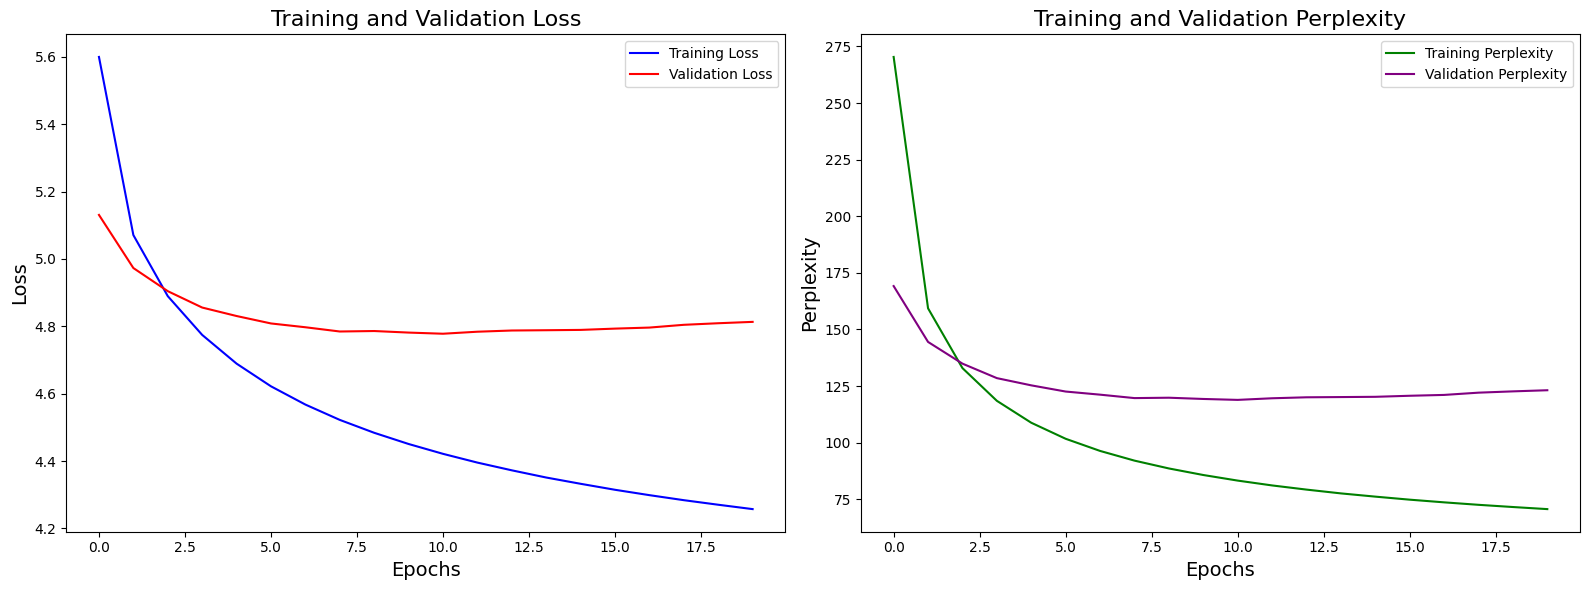

In [ ]:
model.train()
model.test()

## Time step

As we can pick time step ranging from 10 to 30. We will do experiments on three values (10, 20, 30) to see the difference.

###Candidates:
10, 20, 30

We increase time step from 10 to 20 and 30.


254 27 30
Epoch 1/20, Train Loss: 6.3977, Train Perplexity: 600.4563
Epoch 1/20, Validation Loss: 5.7855, Validation Perplexity: 325.5536
Epoch 2/20, Train Loss: 5.7453, Train Perplexity: 312.7063
Epoch 2/20, Validation Loss: 5.4805, Validation Perplexity: 239.9701
Epoch 3/20, Train Loss: 5.4714, Train Perplexity: 237.8028
Epoch 3/20, Validation Loss: 5.2940, Validation Perplexity: 199.1302
Epoch 4/20, Train Loss: 5.3007, Train Perplexity: 200.4692
Epoch 4/20, Validation Loss: 5.1814, Validation Perplexity: 177.9260
Epoch 5/20, Train Loss: 5.1793, Train Perplexity: 177.5551
Epoch 5/20, Validation Loss: 5.1024, Validation Perplexity: 164.4126
Epoch 6/20, Train Loss: 5.0818, Train Perplexity: 161.0655
Epoch 6/20, Validation Loss: 5.0377, Validation Perplexity: 154.1077
Epoch 7/20, Train Loss: 5.0005, Train Perplexity: 148.4907
Epoch 7/20, Validation Loss: 4.9874, Validation Perplexity: 146.5518
Epoch 8/20, Train Loss: 4.9341, Train Perplexity: 138.9515
Epoch 8/20, Validation Loss: 4.9463

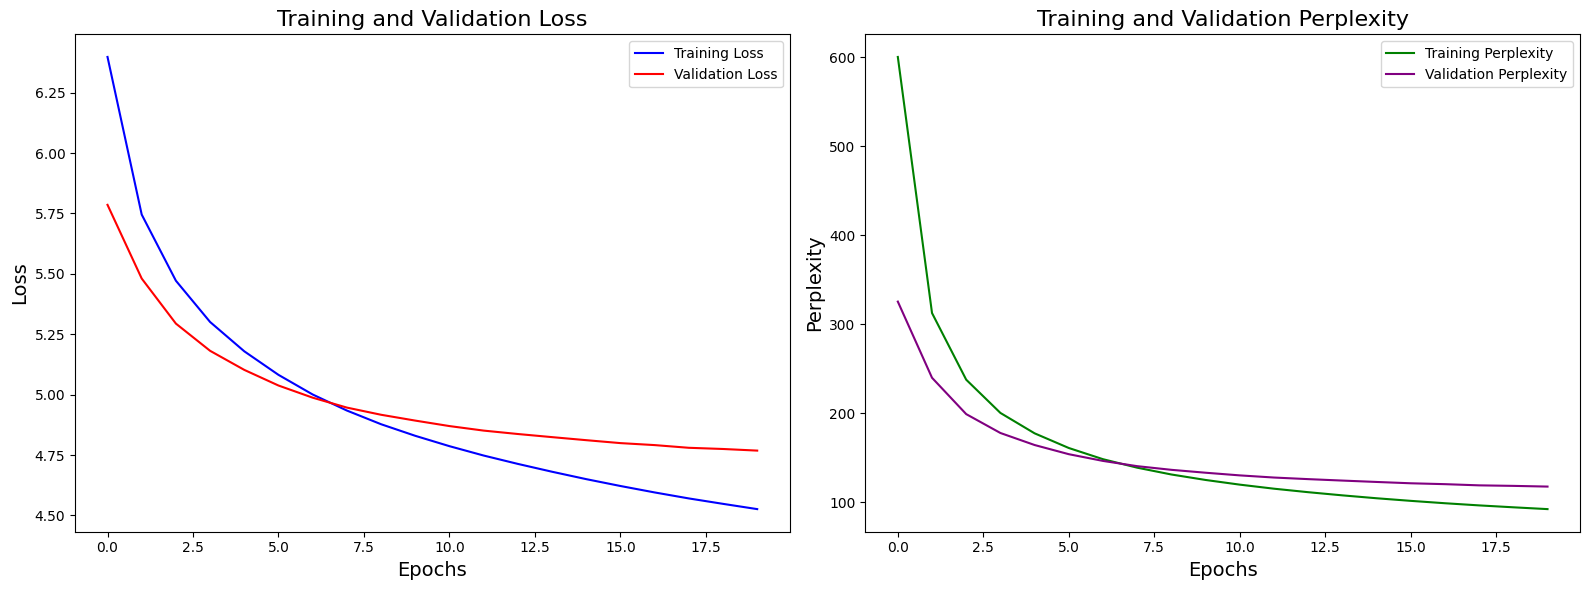

Test Perplexity: 108.919


(4.690603033701579, tensor(108.9189))

In [ ]:
# time step = 20
params = {
    'time_step': 20,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'learning_rate': 0.001,
    'training_shuffle': True,
    'batch_size': 8192,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'weight_decay': False,
    'clip_value': False
}
model = RNNModel(params)
model.to(device)
model.train()
model.test()

2039 213 240
Epoch 1/20, Train Loss: 5.5968, Train Perplexity: 269.5515
Epoch 1/20, Validation Loss: 5.1329, Validation Perplexity: 169.5046
Epoch 2/20, Train Loss: 5.0677, Train Perplexity: 158.8081
Epoch 2/20, Validation Loss: 4.9630, Validation Perplexity: 143.0242
Epoch 3/20, Train Loss: 4.8828, Train Perplexity: 131.9988
Epoch 3/20, Validation Loss: 4.8796, Validation Perplexity: 131.5725
Epoch 4/20, Train Loss: 4.7656, Train Perplexity: 117.3972
Epoch 4/20, Validation Loss: 4.8498, Validation Perplexity: 127.7156
Epoch 5/20, Train Loss: 4.6787, Train Perplexity: 107.6314
Epoch 5/20, Validation Loss: 4.8191, Validation Perplexity: 123.8482
Epoch 6/20, Train Loss: 4.6106, Train Perplexity: 100.5424
Epoch 6/20, Validation Loss: 4.7924, Validation Perplexity: 120.5894
Epoch 7/20, Train Loss: 4.5571, Train Perplexity: 95.3084
Epoch 7/20, Validation Loss: 4.7800, Validation Perplexity: 119.1002
Epoch 8/20, Train Loss: 4.5120, Train Perplexity: 91.1009
Epoch 8/20, Validation Loss: 4.768

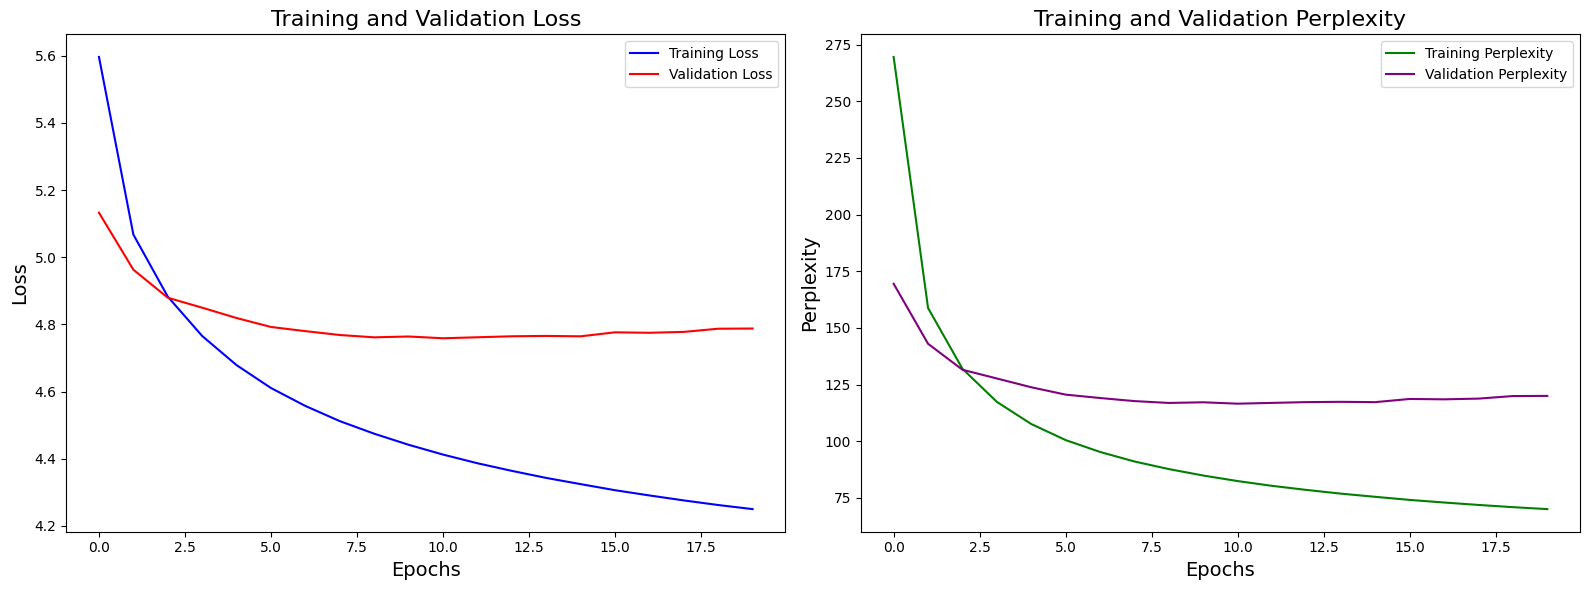

Test Perplexity: 111.982


(4.718335283795993, tensor(111.9817))

In [ ]:
# time step = 30
params = {
    'time_step': 30,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'learning_rate': 0.001,
    'training_shuffle': True,
    'batch_size': 1024,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'weight_decay': False,
    'clip_value': False
}
model = RNNModel(params).to(device)
model.train()
model.test()

As we can see from the results above,

Time step: 10, 20, 30

Corresponding perplexity: 114, 108, 111

**Observation:**

In the range of (10,30), longer time steps normally enable the model to learn better. However, longer time steps do not always bring better results. We need to experiment with different time steps to find the one best fit to our data.

**Conclusion:**

We will use time_step=20

## The size of word embedding
Common dimensions for word embeddings include below. The choice of dimensionality depends on the specific network, the size and complexity of the dataset, and the computational resources available. Higher dimensions can capture more detailed semantics but require more computational power and data to train effectively. Since we should start from 100 dimensions and we do not have a complex network like transformer, we pick 100 and 300 to experiment.

- 50 dimensions: Often used for smaller datasets where the linguistic complexity is lower. This smaller dimension can capture basic semantic relationships with less computational cost.
- 100 dimensions: This is a middle-ground choice, balancing between capturing sufficient semantic detail and maintaining manageable computational requirements.
- 300 dimensions: This is one of the most common dimensions used, especially in models like Word2Vec or GloVe trained on large text corpora. It offers a good balance between detailed semantic capture and computational efficiency.
- 768 dimensions: Embeddings like those from BERT (a transformer-based model) use this size, offering very detailed representations of word meanings based on broader contexts.
- 1024 dimensions and beyond: Used in even larger and more complex models such as GPT-3 and newer versions of BERT, these higher-dimensional embeddings can capture nuanced meanings and relationships but at the cost of increased computational resources.


### Candidates:
100, 300

We increase word embedding size from 100 to 300.


2039 213 240
Epoch 1/20, Train Loss: 5.5278, Train Perplexity: 251.5985
Epoch 1/20, Validation Loss: 5.0883, Validation Perplexity: 162.1081
Epoch 2/20, Train Loss: 5.0040, Train Perplexity: 149.0123
Epoch 2/20, Validation Loss: 4.9329, Validation Perplexity: 138.7871
Epoch 3/20, Train Loss: 4.8236, Train Perplexity: 124.4136
Epoch 3/20, Validation Loss: 4.8696, Validation Perplexity: 130.2704
Epoch 4/20, Train Loss: 4.7116, Train Perplexity: 111.2249
Epoch 4/20, Validation Loss: 4.8370, Validation Perplexity: 126.0868
Epoch 5/20, Train Loss: 4.6319, Train Perplexity: 102.7053
Epoch 5/20, Validation Loss: 4.8209, Validation Perplexity: 124.0707
Epoch 6/20, Train Loss: 4.5701, Train Perplexity: 96.5549
Epoch 6/20, Validation Loss: 4.8144, Validation Perplexity: 123.2729
Epoch 7/20, Train Loss: 4.5199, Train Perplexity: 91.8229
Epoch 7/20, Validation Loss: 4.8038, Validation Perplexity: 121.9673
Epoch 8/20, Train Loss: 4.4780, Train Perplexity: 88.0544
Epoch 8/20, Validation Loss: 4.8031

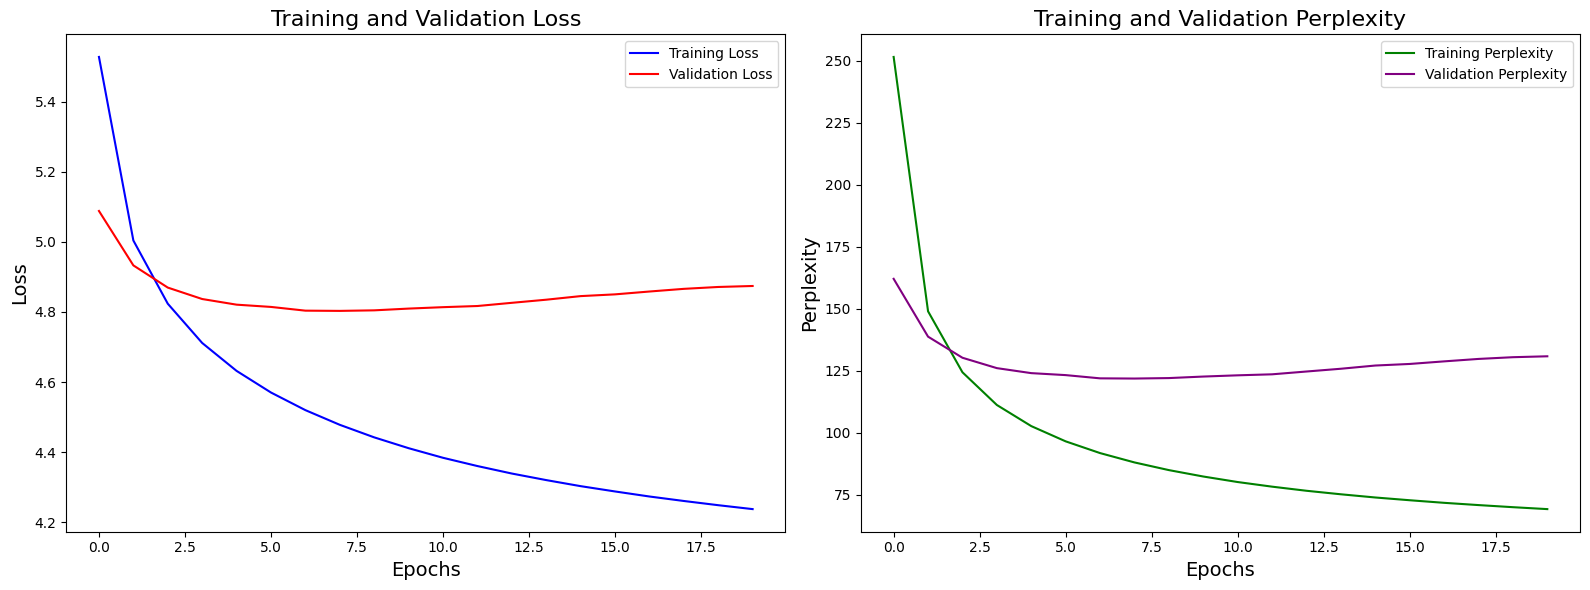

Test Perplexity: 122.467


(4.807839179039002, tensor(122.4667))

In [ ]:
# embedding_dim = 300
params = {
    'embedding_dim': 300,
    'time_step': 10,
    'hidden_dim': 100,
    'learning_rate': 0.001,
    'training_shuffle': True,
    'batch_size': 1024,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'weight_decay': False,
    'clip_value': False
}
model = RNNModel(params).to(device)
model.train()
model.test()

As we can see from the results above,

word embedding size: 100, 300

Corresponding perplexity: 114, 122

**Observation:**

The performance degrades after we increase the size of word embedding. The reasons might be follows:

1. The model already encounters overfitting problem. Increasing the size of the word embeddings increases the dimensionality of the input data and number of paramters, which can exacerbate overfitting.
2. Our dataset is not large enough to support learning such a high-dimensional representation. If the training data is limited, the model may learn to memorize the training set rather than generalizing from it.

**Conclusion:**

We will use embedding_dim=100

## The size of hidden state

The hidden state size does not have to be equal to the input size.
The hidden state size in RNNs determines the capacity of the network to capture information from past inputs. There is no one-size-fits-all answer, but here are common practices:

- Small Datasets and Simpler Problems: Typically consists of a few hundred to a few thousand samples. Hidden state sizes can range from 50 to 200 units. Smaller hidden states reduce the risk of overfitting on limited data.
- Medium to Large Datasets: Count: Ranges from tens of thousands to a few hundred thousand samples. For tabular data, this might be between 10,000 and 500,000 records. Hidden state sizes can range from 200 to 600 units. Larger hidden states can capture more information and nuances from the input sequences.
- Very Complex Tasks: In tasks like large-scale language modeling or sequence-to-sequence models, hidden state sizes can be even larger, ranging from 600 to 2000 units or more, depending on computational resources and the specific requirements of the task.

### Candidates

100, 200, 500

We increase hidden state size from 100 to 200 and 500.

2039 213 240
Epoch 1/20, Train Loss: 5.5033, Train Perplexity: 245.4981
Epoch 1/20, Validation Loss: 5.0589, Validation Perplexity: 157.4127
Epoch 2/20, Train Loss: 4.9304, Train Perplexity: 138.4326
Epoch 2/20, Validation Loss: 4.8824, Validation Perplexity: 131.9476
Epoch 3/20, Train Loss: 4.7086, Train Perplexity: 110.8953
Epoch 3/20, Validation Loss: 4.8213, Validation Perplexity: 124.1286
Epoch 4/20, Train Loss: 4.5688, Train Perplexity: 96.4240
Epoch 4/20, Validation Loss: 4.7783, Validation Perplexity: 118.8966
Epoch 5/20, Train Loss: 4.4682, Train Perplexity: 87.2026
Epoch 5/20, Validation Loss: 4.7632, Validation Perplexity: 117.1186
Epoch 6/20, Train Loss: 4.3899, Train Perplexity: 80.6339
Epoch 6/20, Validation Loss: 4.7678, Validation Perplexity: 117.6590
Epoch 7/20, Train Loss: 4.3258, Train Perplexity: 75.6245
Epoch 7/20, Validation Loss: 4.7659, Validation Perplexity: 117.4383
Epoch 8/20, Train Loss: 4.2710, Train Perplexity: 71.5958
Epoch 8/20, Validation Loss: 4.7720, 

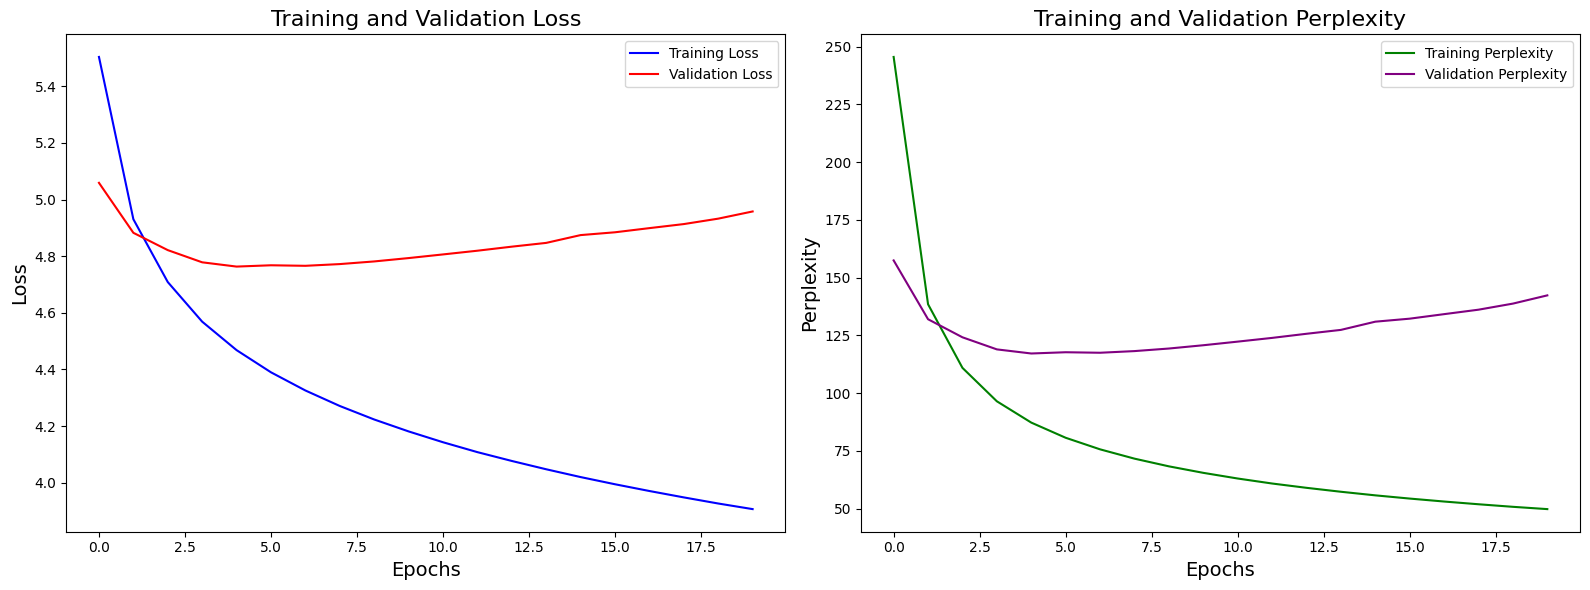

Test Perplexity: 132.937


(4.889872124791145, tensor(132.9366))

In [ ]:
# hidden_dim = 200
params = {
    'hidden_dim': 200,
    'embedding_dim': 100,
    'time_step': 10,
    'learning_rate': 0.001,
    'training_shuffle': True,
    'batch_size': 1024,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'weight_decay': False,
    'clip_value': False
}
model = RNNModel(params).to(device)
model.train()
model.test()

2039 213 240
Epoch 1/20, Train Loss: 5.4741, Train Perplexity: 238.4309
Epoch 1/20, Validation Loss: 5.0111, Validation Perplexity: 150.0654
Epoch 2/20, Train Loss: 4.8287, Train Perplexity: 125.0529
Epoch 2/20, Validation Loss: 4.8731, Validation Perplexity: 130.7216
Epoch 3/20, Train Loss: 4.5542, Train Perplexity: 95.0262
Epoch 3/20, Validation Loss: 4.8477, Validation Perplexity: 127.4406
Epoch 4/20, Train Loss: 4.3628, Train Perplexity: 78.4726
Epoch 4/20, Validation Loss: 4.8599, Validation Perplexity: 129.0156
Epoch 5/20, Train Loss: 4.2159, Train Perplexity: 67.7560
Epoch 5/20, Validation Loss: 4.8986, Validation Perplexity: 134.1033
Epoch 6/20, Train Loss: 4.0966, Train Perplexity: 60.1384
Epoch 6/20, Validation Loss: 4.9365, Validation Perplexity: 139.2819
Epoch 7/20, Train Loss: 3.9963, Train Perplexity: 54.3985
Epoch 7/20, Validation Loss: 4.9804, Validation Perplexity: 145.5327
Epoch 8/20, Train Loss: 3.9096, Train Perplexity: 49.8793
Epoch 8/20, Validation Loss: 5.0281, V

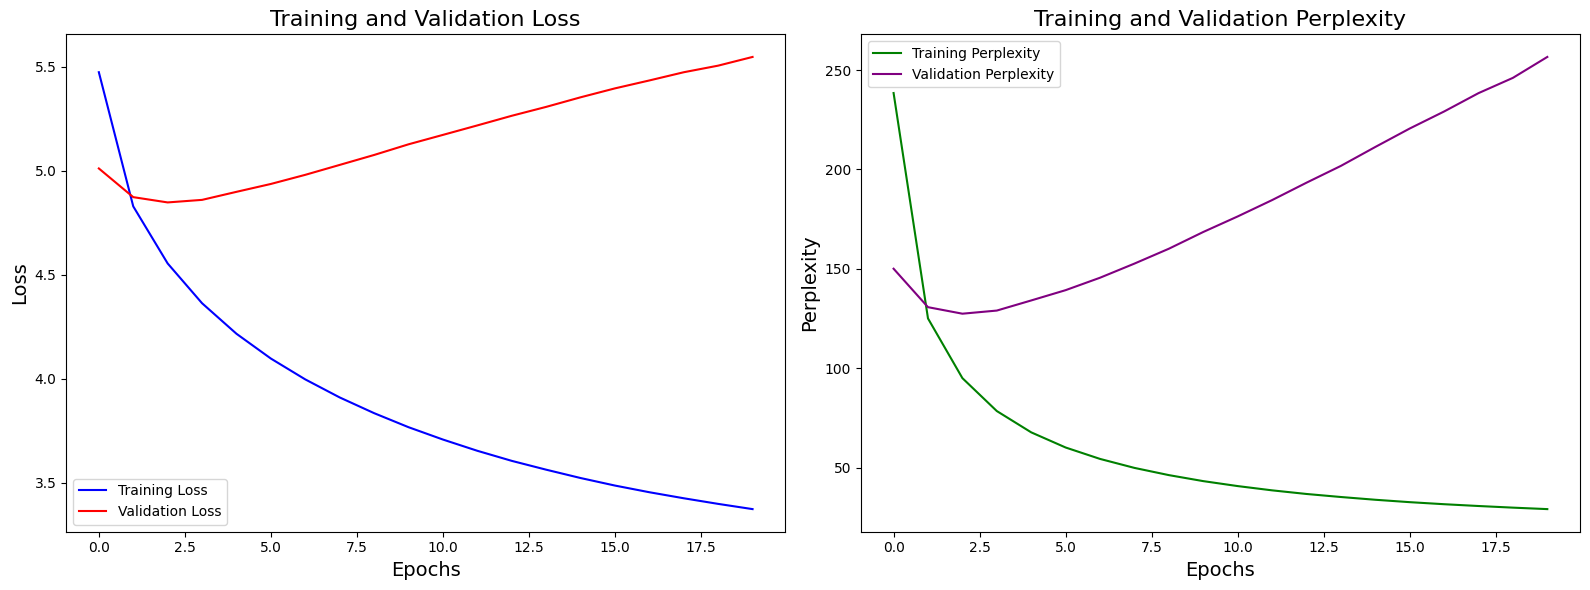

Test Perplexity: 237.228


(5.469023249546686, tensor(237.2284))

In [ ]:
# hidden_dim = 500
params = {
    'hidden_dim': 500,
    'embedding_dim': 100,
    'time_step': 10,
    'learning_rate': 0.001,
    'training_shuffle': True,
    'batch_size': 1024,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'weight_decay': False,
    'clip_value': False
}
model = RNNModel(params).to(device)
model.train()
model.test()

As we can see from the results above,

hidden state size: 100, 200, 500

Corresponding perplexity: 114, 132, 237

**Observation:**

The performance of my rnn model degrades after we increase the size of hidden state from 100 to 500.
1. Increasing the size of the hidden state increases the complexity of the RNN model. A larger hidden state means the model has more parameters and thus a greater capacity to learn from the training data. While this can be beneficial for capturing more nuanced patterns and dependencies, it can also lead the model to learn irrelevant details and noise from the training data, leading to overfitting, especially our model already faces overfitting problem when hidden size=100.
2. Our dataset is not huge, a model with a large number of parameters (due to a large hidden state) is likely to overfit.

**Conclusion:**

We will use hidden_dim=100

## Learning Rate

A typical starting learning rate for RNNs can range from 0.001 to 0.01. This range is broad enough to encompass different scenarios from slow, careful learning to more aggressive updates.  We will do experiments on two values (0.001, 0.01) to see the difference.

### Candidates:
(0.001, 0.01)

We increase learning_rate from 0.001 to 0.01.

2039 213 240
Epoch 1/20, Train Loss: 5.5652, Train Perplexity: 261.1718
Epoch 1/20, Validation Loss: 5.3404, Validation Perplexity: 208.5893
Epoch 2/20, Train Loss: 5.3109, Train Perplexity: 202.5339
Epoch 2/20, Validation Loss: 5.3652, Validation Perplexity: 213.8362
Epoch 3/20, Train Loss: 5.3218, Train Perplexity: 204.7430
Epoch 3/20, Validation Loss: 5.3904, Validation Perplexity: 219.2932
Epoch 4/20, Train Loss: 5.3560, Train Perplexity: 211.8764
Epoch 4/20, Validation Loss: 5.4614, Validation Perplexity: 235.4166
Epoch 5/20, Train Loss: 5.3855, Train Perplexity: 218.2284
Epoch 5/20, Validation Loss: 5.4801, Validation Perplexity: 239.8760
Epoch 6/20, Train Loss: 5.4195, Train Perplexity: 225.7660
Epoch 6/20, Validation Loss: 5.5009, Validation Perplexity: 244.9217
Epoch 7/20, Train Loss: 5.4254, Train Perplexity: 227.0928
Epoch 7/20, Validation Loss: 5.5026, Validation Perplexity: 245.3284
Epoch 8/20, Train Loss: 5.4271, Train Perplexity: 227.4917
Epoch 8/20, Validation Loss: 5.5

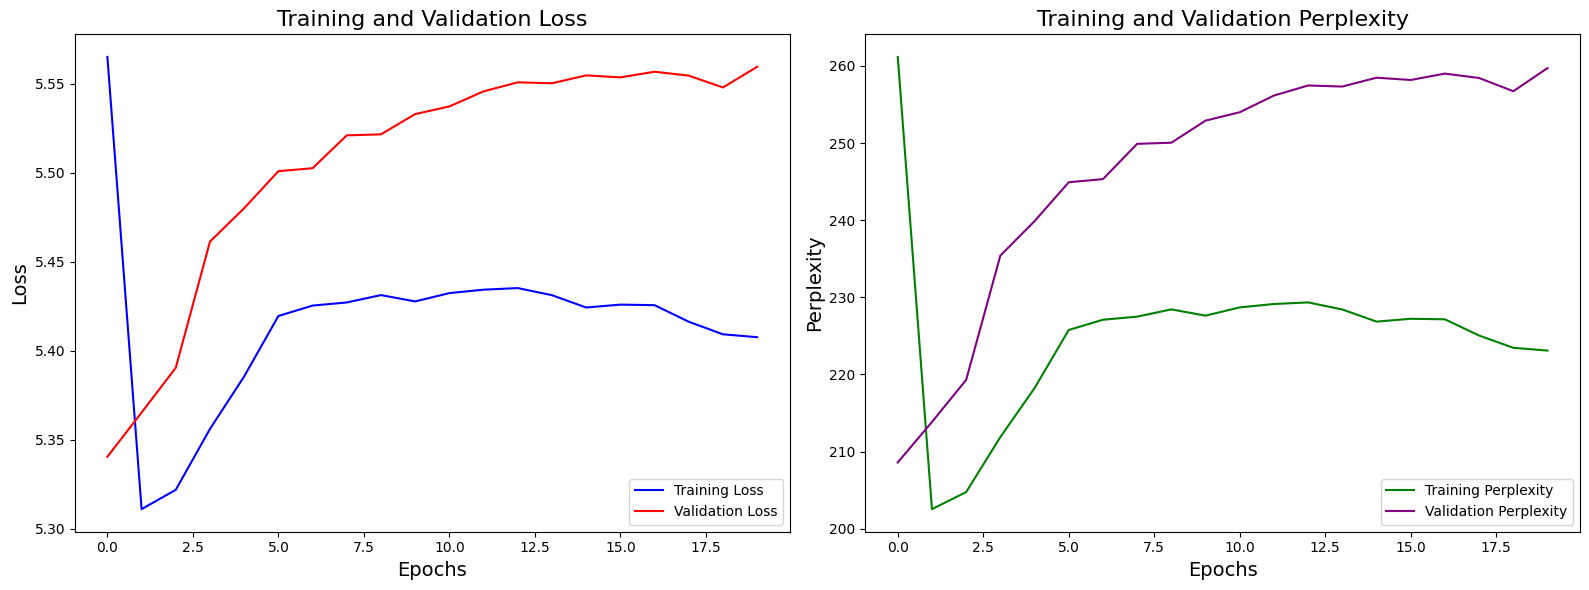

Test Perplexity: 240.616


(5.483203174670537, tensor(240.6163))

In [ ]:
params = {
    'learning_rate': 0.01,
    'hidden_dim': 100,
    'embedding_dim': 100,
    'time_step': 10,
    'training_shuffle': True,
    'batch_size': 1024,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'weight_decay': False,
    'clip_value': False
}
model = RNNModel(params).to(device)
model.train()
model.test()

As we can see from the results above,

learning rate: 0.001, 0.01

Corresponding perplexity: 114, 240

**Observation:**
learning rate is too high. Although it learns fast at the beginning, the models steps over the optimum and loss further increases.

**Conclusion:**

We will use learning rate=0.001

## Training shuffle

This choice will affect whether we carry over hidden state from one batch to the next:

If we shuffle the training data, we disrupt the natural sequence order of continuous text or stories. In such cases, we will not carry over the hidden state from one batch to the next, as each batch does not sequentially follow the previous one. Initializing hidden state at the beginning of each batch ensures that the model treats each batch (or sequence within a batch) independently, without inappropriate context from unrelated text sequences.

If we do not shuffle training data and the sequences form part of a continuous text, carrying over the hidden state from one batch to the next during training can be beneficial. This helps the model maintain context across different parts of the text, improving its ability to learn dependencies and predict subsequent words more accurately.

### Candidates:
(True, False)

We change to not shuffling training data and pass on the hidden state to the next batch.

2039 213 240
Epoch 1/20, Train Loss: 5.7656, Train Perplexity: 319.1159
Epoch 1/20, Validation Loss: 5.2685, Validation Perplexity: 194.1159
Epoch 2/20, Train Loss: 5.2474, Train Perplexity: 190.0697
Epoch 2/20, Validation Loss: 5.1174, Validation Perplexity: 166.9029
Epoch 3/20, Train Loss: 5.0685, Train Perplexity: 158.9410
Epoch 3/20, Validation Loss: 5.0553, Validation Perplexity: 156.8570
Epoch 4/20, Train Loss: 4.9530, Train Perplexity: 141.5935
Epoch 4/20, Validation Loss: 5.0259, Validation Perplexity: 152.3070
Epoch 5/20, Train Loss: 4.8676, Train Perplexity: 130.0139
Epoch 5/20, Validation Loss: 5.0072, Validation Perplexity: 149.4842
Epoch 6/20, Train Loss: 4.8005, Train Perplexity: 121.5721
Epoch 6/20, Validation Loss: 4.9962, Validation Perplexity: 147.8503
Epoch 7/20, Train Loss: 4.7457, Train Perplexity: 115.0827
Epoch 7/20, Validation Loss: 4.9888, Validation Perplexity: 146.7651
Epoch 8/20, Train Loss: 4.6994, Train Perplexity: 109.8865
Epoch 8/20, Validation Loss: 4.9

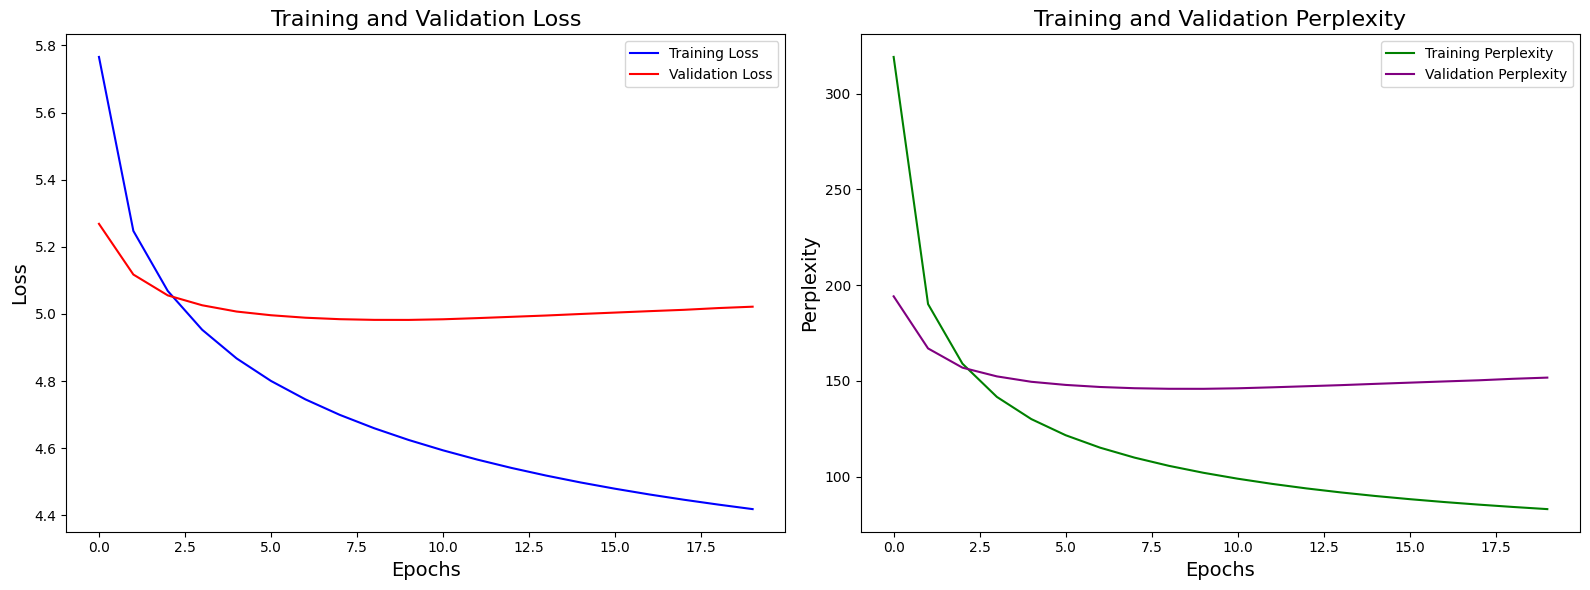

Test Perplexity: 140.368


(4.94426750143369, tensor(140.3680))

In [ ]:
params = {
    'training_shuffle': False,
    'learning_rate': 0.001,
    'hidden_dim': 100,
    'embedding_dim': 100,
    'time_step': 10,
    'batch_size': 1024,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'weight_decay': False,
    'clip_value': False
}
model = RNNModel(params).to(device)
model.train()
model.test()

As we can see from the results above,

training shuffle: True, False

Corresponding perplexity: 114, 140

**Observation:**
Carrying over the hidden state from one batch to the next and not shuffling our training data degrades the performance. Reasons may be as follows:

1. If the batches are not actual continuations of each other, then the hidden state from the end of one batch carries irrelevant information into the beginning of the next batch. In our case, although we make sure the continuity of the sequences by not shuffling training data. However, when they are separated into batches, the corresponding sequences between batches are not continuous any more. The continuity is only valid when batch size=1(to be confirmed?).

2. By always maintaining the sequence order and carrying over states, the model might overfit to the specific order and structure of your training data, reducing its ability to generalize to unseen data where the sequence order or structure might be different.


**Conclusion:**

We will use training_shuffle=True

Let's use the combination with all best parameters to form a baseline for Question 2.

2039 213 240
Epoch 1/20, Train Loss: 5.6086, Train Perplexity: 272.7523
Epoch 1/20, Validation Loss: 5.1385, Validation Perplexity: 170.4524
Epoch 2/20, Train Loss: 5.0677, Train Perplexity: 158.8073
Epoch 2/20, Validation Loss: 4.9607, Validation Perplexity: 142.6879
Epoch 3/20, Train Loss: 4.8828, Train Perplexity: 132.0038
Epoch 3/20, Validation Loss: 4.8835, Validation Perplexity: 132.0978
Epoch 4/20, Train Loss: 4.7681, Train Perplexity: 117.6958
Epoch 4/20, Validation Loss: 4.8465, Validation Perplexity: 127.2960
Epoch 5/20, Train Loss: 4.6853, Train Perplexity: 108.3436
Epoch 5/20, Validation Loss: 4.8213, Validation Perplexity: 124.1265
Epoch 6/20, Train Loss: 4.6161, Train Perplexity: 101.1010
Epoch 6/20, Validation Loss: 4.7948, Validation Perplexity: 120.8744
Epoch 7/20, Train Loss: 4.5598, Train Perplexity: 95.5614
Epoch 7/20, Validation Loss: 4.7770, Validation Perplexity: 118.7435
Epoch 8/20, Train Loss: 4.5157, Train Perplexity: 91.4423
Epoch 8/20, Validation Loss: 4.773

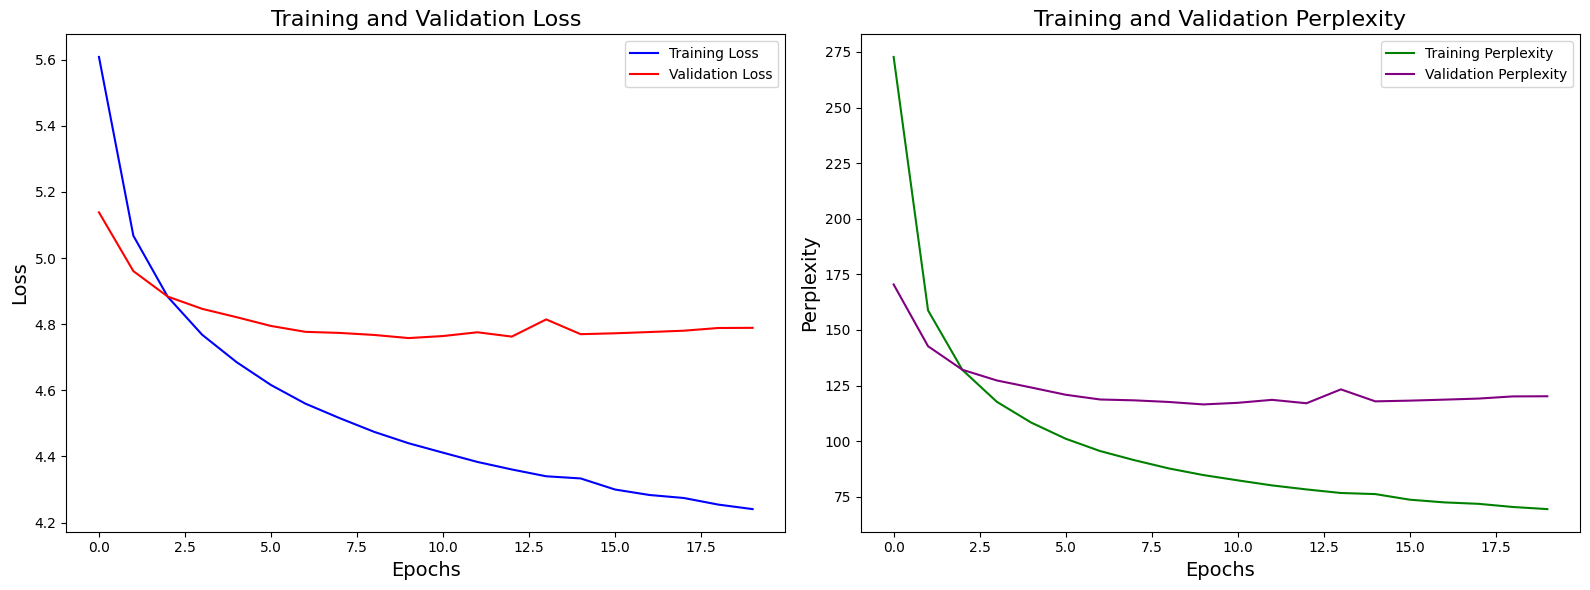

Test Perplexity: 111.768


(4.716424255569776, tensor(111.7679))

In [ ]:
params = {
    'training_shuffle': True,
    'learning_rate': 0.001,
    'hidden_dim': 100,
    'embedding_dim': 100,
    'time_step': 20,
    'batch_size': 1024,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'weight_decay': False,
    'clip_value': False
}
model = RNNModel(params).to(device)
model.train()
model.test()

# Question 2
Discuss how you might improve this “vanilla” RNN language modeling
architecture.

- **Regularization Techniques:**
    - **Weight Regularization**: Adding L1 or L2 regularization to the weights can also help in preventing overfitting.
      - As we can see from above, there is overfitting problem. We will use L2 weight decay to minimize the overfitting.
- **Optimization and Training Techniques:**
    - **Gradient Clipping**: This is crucial for preventing the exploding gradient problem in RNNs. It limits the size of the gradients during backpropagation to ensure stable training.
      - We will implement Gradient Clipping
- **Architectural Tweaks:**
    - **Stacked RNN Layers**: Increase the model's capacity by adding more layers. However, be mindful of the increased computational cost and the potential for overfitting.
      - We will use 2 layers to compare the result.
- **Advanced RNN Architectures:**
    - **LSTM and GRU**: Vanilla RNNs suffer from vanishing and exploding gradient problems, making them less effective for learning long-term dependencies. Long Short-Term Memory (LSTM) units or Gated Recurrent Units (GRU) are more sophisticated variants that can capture long-range dependencies better, improving the model's performance on tasks requiring understanding of longer context.
      - We will change the current structure to LSTM.
    - **Bidirectional RNNs**: These process the data in both forward and backward directions, providing a richer representation of the context which can improve the model's understanding and predictions.
- **Embedding Layer Improvements:**
    - **Pre-trained Word Embeddings**: Instead of learning word embeddings from scratch, use pre-trained embeddings like GloVe or Word2Vec. These can provide a good starting point and add external knowledge to your model.
      - Since it needs extra pretrained model here, we will not implement this one.

# Question 3
Implement one (or more) of the improvements mentioned above, and
provide a new set of learning curves and final test perplexity.

## 1. Add L2 weight decay

As we can see from above, there is overfitting problem. We will use L2 weight decay to tackle the problem.

Here, we use weight decay=0.0001

2039 213 240
Epoch 1/20, Train Loss: 5.7723, Train Perplexity: 321.2730
Epoch 1/20, Validation Loss: 5.2735, Validation Perplexity: 195.1057
Epoch 2/20, Train Loss: 5.2507, Train Perplexity: 190.6945
Epoch 2/20, Validation Loss: 5.0568, Validation Perplexity: 157.0829
Epoch 3/20, Train Loss: 5.0935, Train Perplexity: 162.9517
Epoch 3/20, Validation Loss: 4.9778, Validation Perplexity: 145.1491
Epoch 4/20, Train Loss: 5.0041, Train Perplexity: 149.0203
Epoch 4/20, Validation Loss: 4.9111, Validation Perplexity: 135.7868
Epoch 5/20, Train Loss: 4.9454, Train Perplexity: 140.5272
Epoch 5/20, Validation Loss: 4.8684, Validation Perplexity: 130.1153
Epoch 6/20, Train Loss: 4.9068, Train Perplexity: 135.2065
Epoch 6/20, Validation Loss: 4.8451, Validation Perplexity: 127.1105
Epoch 7/20, Train Loss: 4.8787, Train Perplexity: 131.4576
Epoch 7/20, Validation Loss: 4.8292, Validation Perplexity: 125.1170
Epoch 8/20, Train Loss: 4.8584, Train Perplexity: 128.8153
Epoch 8/20, Validation Loss: 4.8

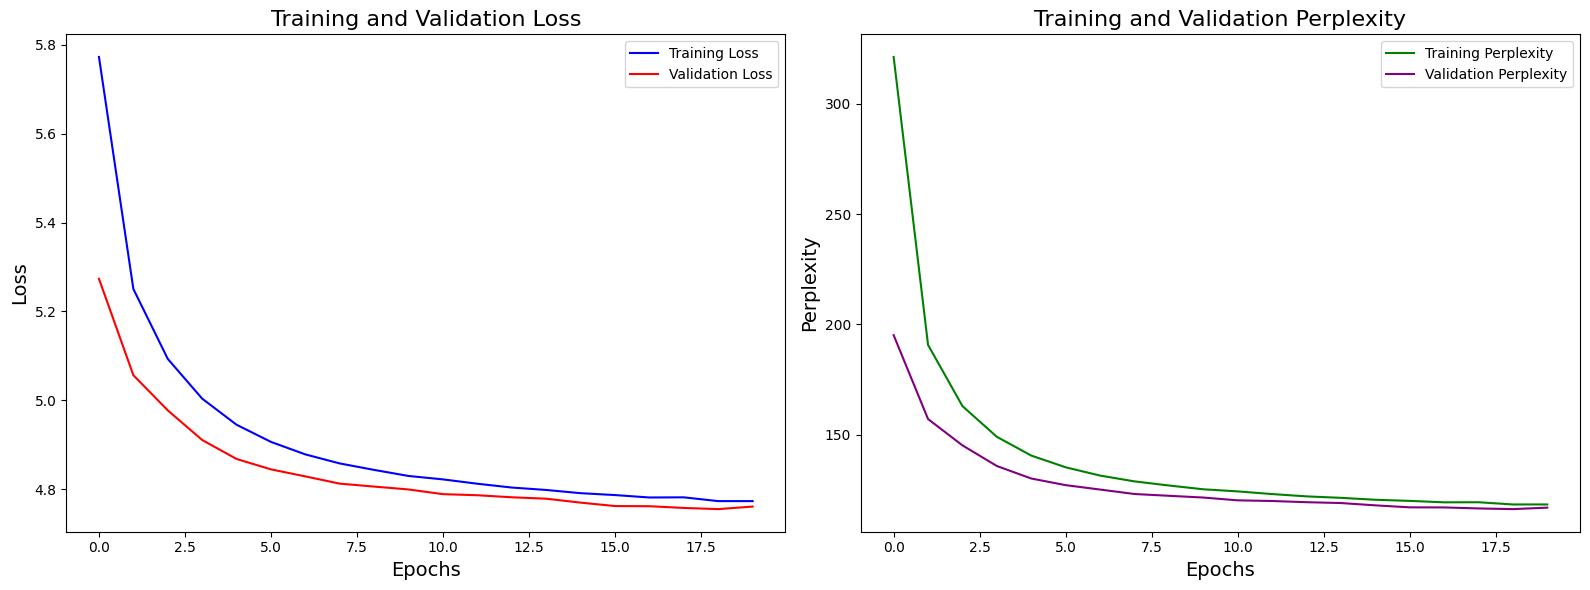

Test Perplexity: 108.466


(4.686438672741255, tensor(108.4662))

In [26]:
params = {
    'batch_size': 1024,
    'time_step': 20,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'learning_rate': 0.001,
    'training_shuffle': True,
    'weight_decay': 0.0001,
    'clip_value': False
}
model = RNNModel(params).to(device)
model.train()
model.test()

**Conclusion**

After we use L2 weight decay to minimize the overfitting, it significantly reduced the overfitting problem.

## 2. Add Gradient Clipping

RNN is particularly prone to the exploding gradient problem due to their inherent structure and the way they learn temporal dependencies from data. This susceptibility is primarily due to the repeated multiplication of gradients through time during the backpropagation through time (BPTT) process, which is used to train RNNs. In RNNs, the hidden state at each timestep is a function of the previous hidden state and the current input. This recurrence relation means that the hidden state is effectively a product of all previous hidden states and inputs. During backpropagation, this leads to gradients being multiplied through each timestep.

Gradient Clipping limits the size of the gradients during backpropagation to ensure stable training.

Below are experiments with clip values of 1 and 5.

2039 213 240
Epoch 1/20, Train Loss: 5.6987, Train Perplexity: 298.4898
Epoch 1/20, Validation Loss: 5.2124, Validation Perplexity: 183.5416
Epoch 2/20, Train Loss: 5.1897, Train Perplexity: 179.4158
Epoch 2/20, Validation Loss: 5.0122, Validation Perplexity: 150.2352
Epoch 3/20, Train Loss: 5.0512, Train Perplexity: 156.2124
Epoch 3/20, Validation Loss: 4.9423, Validation Perplexity: 140.0855
Epoch 4/20, Train Loss: 4.9796, Train Perplexity: 145.4152
Epoch 4/20, Validation Loss: 4.8943, Validation Perplexity: 133.5242
Epoch 5/20, Train Loss: 4.9294, Train Perplexity: 138.2976
Epoch 5/20, Validation Loss: 4.8727, Validation Perplexity: 130.6701
Epoch 6/20, Train Loss: 4.8959, Train Perplexity: 133.7449
Epoch 6/20, Validation Loss: 4.8455, Validation Perplexity: 127.1658
Epoch 7/20, Train Loss: 4.8723, Train Perplexity: 130.6230
Epoch 7/20, Validation Loss: 4.8273, Validation Perplexity: 124.8695
Epoch 8/20, Train Loss: 4.8554, Train Perplexity: 128.4340
Epoch 8/20, Validation Loss: 4.8

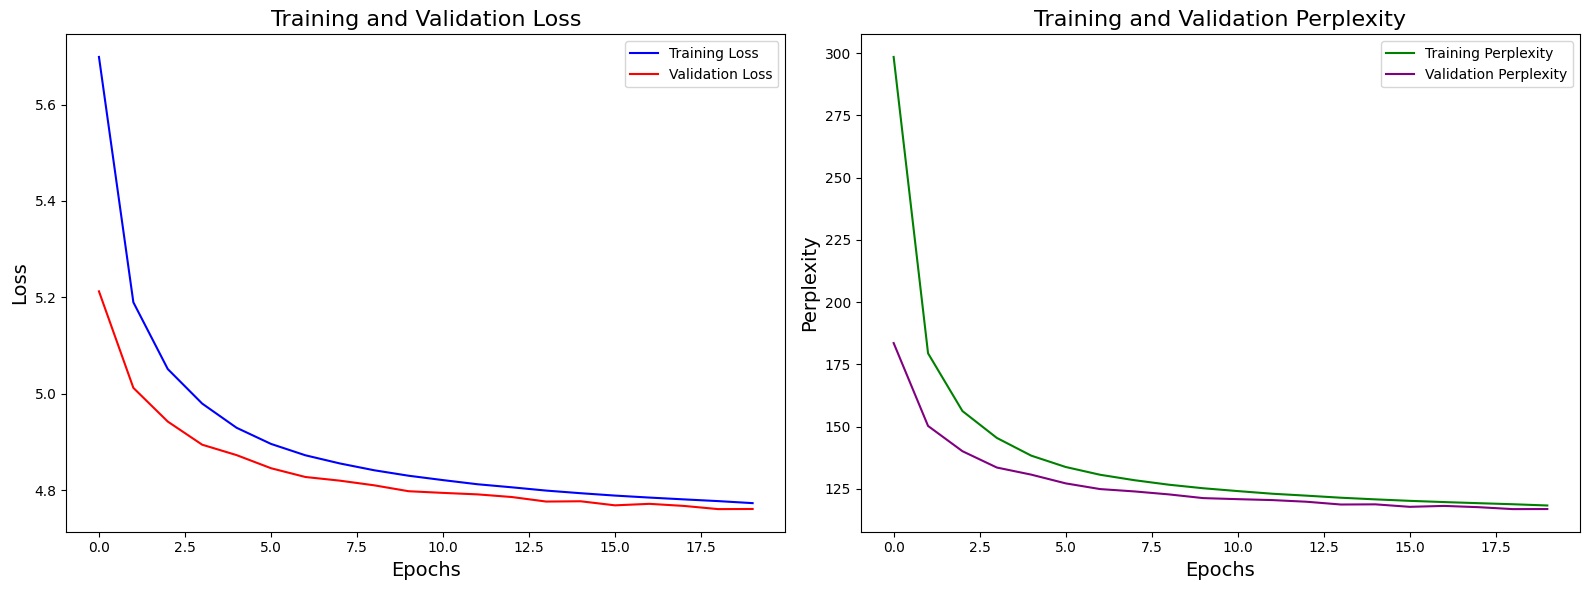

Test Perplexity: 108.121


(4.683248348037401, tensor(108.1207))

In [24]:
params = {
    'batch_size': 1024,
    'time_step': 20,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'learning_rate': 0.001,
    'training_shuffle': True,
    'weight_decay': 0.0001,
    'clip_value': 1
}
model = RNNModel(params).to(device)
model.train()
model.test()

2039 213 240
Epoch 1/20, Train Loss: 5.7258, Train Perplexity: 306.6711
Epoch 1/20, Validation Loss: 5.2308, Validation Perplexity: 186.9500
Epoch 2/20, Train Loss: 5.2116, Train Perplexity: 183.3811
Epoch 2/20, Validation Loss: 5.0254, Validation Perplexity: 152.2380
Epoch 3/20, Train Loss: 5.0590, Train Perplexity: 157.4343
Epoch 3/20, Validation Loss: 4.9440, Validation Perplexity: 140.3322
Epoch 4/20, Train Loss: 4.9757, Train Perplexity: 144.8571
Epoch 4/20, Validation Loss: 4.8891, Validation Perplexity: 132.8295
Epoch 5/20, Train Loss: 4.9277, Train Perplexity: 138.0670
Epoch 5/20, Validation Loss: 4.8633, Validation Perplexity: 129.4474
Epoch 6/20, Train Loss: 4.8957, Train Perplexity: 133.7177
Epoch 6/20, Validation Loss: 4.8462, Validation Perplexity: 127.2546
Epoch 7/20, Train Loss: 4.8719, Train Perplexity: 130.5654
Epoch 7/20, Validation Loss: 4.8334, Validation Perplexity: 125.6387
Epoch 8/20, Train Loss: 4.8539, Train Perplexity: 128.2403
Epoch 8/20, Validation Loss: 4.8

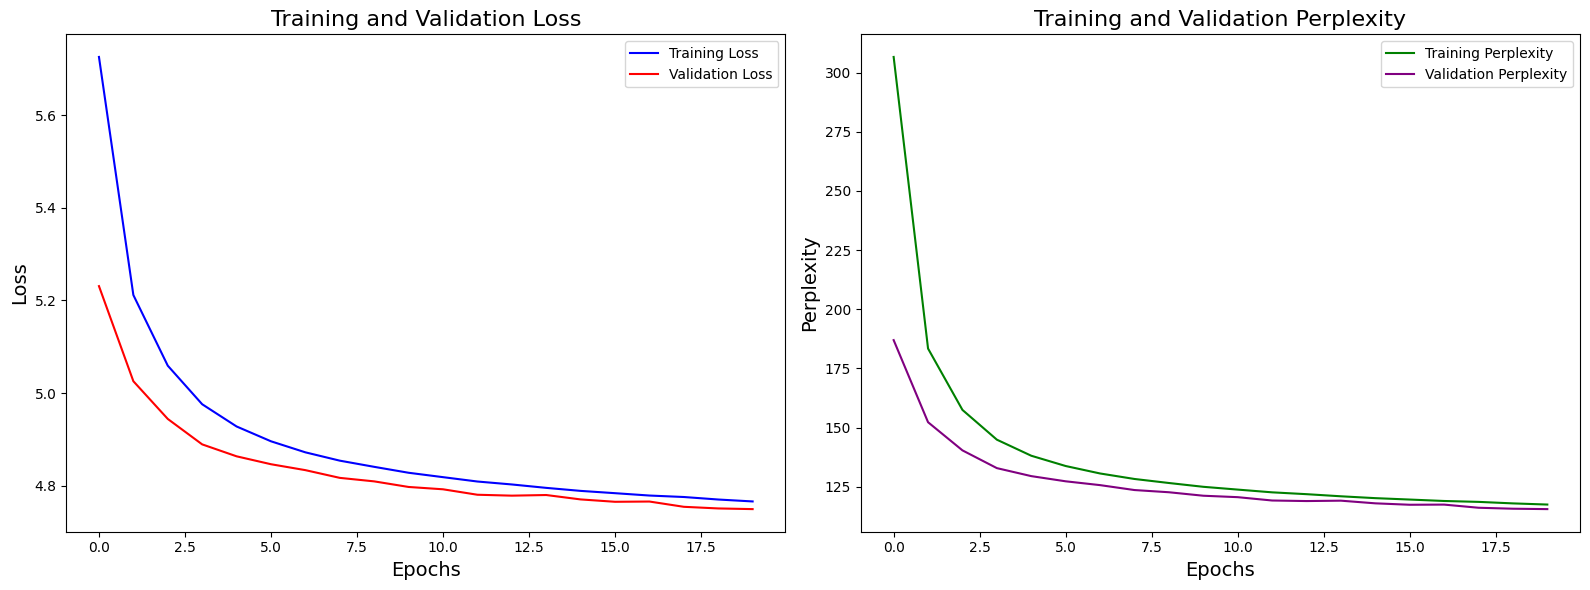

Test Perplexity: 107.547


(4.677925340334574, tensor(107.5467))

In [25]:
params = {
    'batch_size': 1024,
    'time_step': 20,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'learning_rate': 0.001,
    'training_shuffle': True,
    'weight_decay': 0.0001,
    'clip_value': 5
}
model = RNNModel(params).to(device)
model.train()
model.test()

**Conclusion**

Since we have not met with exploding gradients so far, it is not that effective in increasing performance.

## 3. Add RNN layers
We want to increase the model's capacity by adding more layers. Here, we will increase from 1 RNN layer to 2 layers. However, we should be be mindful of the increased computational cost and the potential for overfitting. Therefore, we will try no dropout and with dropout.



### No dropout
rnn_layers=2, dropout=0

🌟🌟 This is the best model we have achieved with perplexity of 99.

2039 213 240
Epoch 1/20, Train Loss: 5.7071, Train Perplexity: 300.9989
Epoch 1/20, Validation Loss: 5.1871, Validation Perplexity: 178.9447
Epoch 2/20, Train Loss: 5.1477, Train Perplexity: 172.0294
Epoch 2/20, Validation Loss: 4.9689, Validation Perplexity: 143.8657
Epoch 3/20, Train Loss: 4.9806, Train Perplexity: 145.5660
Epoch 3/20, Validation Loss: 4.8786, Validation Perplexity: 131.4502
Epoch 4/20, Train Loss: 4.8970, Train Perplexity: 133.8850
Epoch 4/20, Validation Loss: 4.8340, Validation Perplexity: 125.7120
Epoch 5/20, Train Loss: 4.8478, Train Perplexity: 127.4603
Epoch 5/20, Validation Loss: 4.8018, Validation Perplexity: 121.7338
Epoch 6/20, Train Loss: 4.8150, Train Perplexity: 123.3506
Epoch 6/20, Validation Loss: 4.7834, Validation Perplexity: 119.5104
Epoch 7/20, Train Loss: 4.7897, Train Perplexity: 120.2704
Epoch 7/20, Validation Loss: 4.7609, Validation Perplexity: 116.8490
Epoch 8/20, Train Loss: 4.7693, Train Perplexity: 117.8313
Epoch 8/20, Validation Loss: 4.7

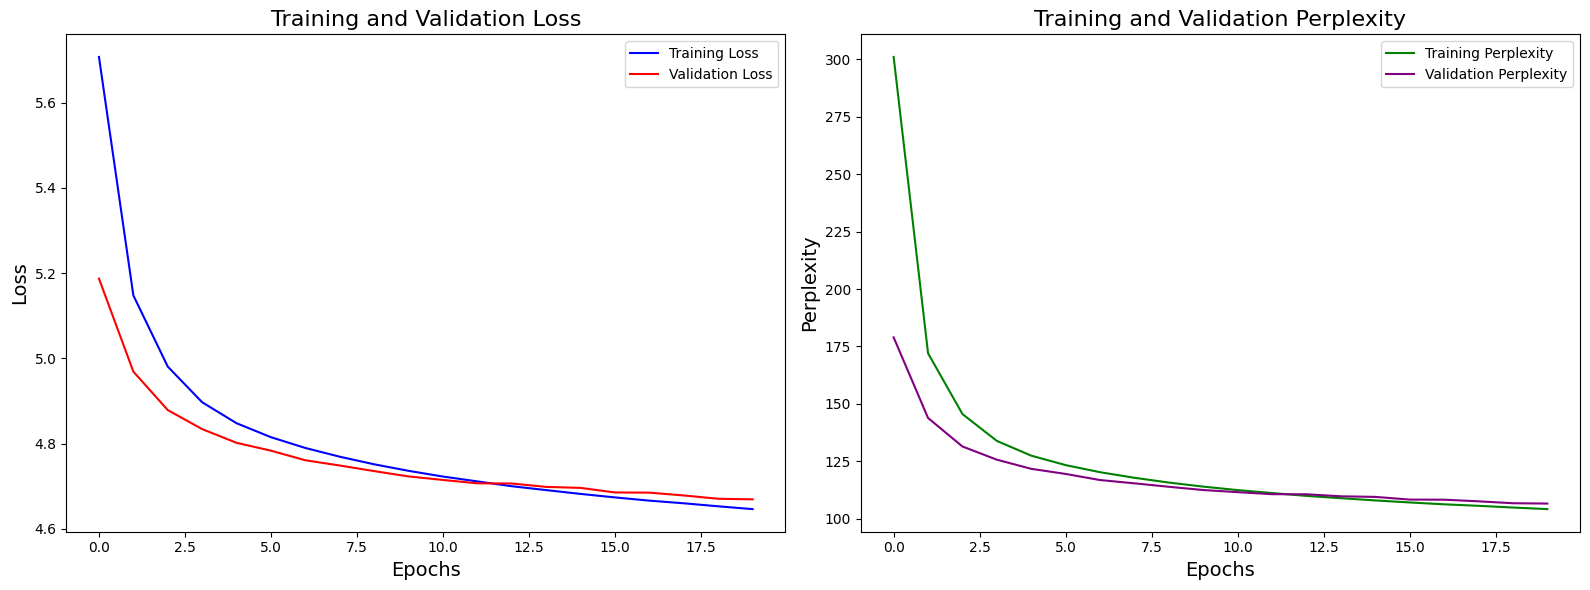

Test Perplexity: 99.313


(4.598280227184295, tensor(99.3134))

In [ ]:
params = {
    'batch_size': 1024,
    'time_step': 20,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'num_rnn_layer': 2,
    'dropout': 0,
    'epoch': 20,
    'learning_rate': 0.001,
    'training_shuffle': True,
    'weight_decay': 0.0001,
    'clip_value': 5
}
model = RNNModel(params).to(device)
model.train()
model.test()

### With dropout
rnn_layers=2, dropout=0.3

1019 107 120
Epoch 1/20, Train Loss: 6.0231, Train Perplexity: 412.8497
Epoch 1/20, Validation Loss: 5.4842, Validation Perplexity: 240.8588
Epoch 2/20, Train Loss: 5.4449, Train Perplexity: 231.5690
Epoch 2/20, Validation Loss: 5.1968, Validation Perplexity: 180.6915
Epoch 3/20, Train Loss: 5.2125, Train Perplexity: 183.5437
Epoch 3/20, Validation Loss: 5.0526, Validation Perplexity: 156.4254
Epoch 4/20, Train Loss: 5.0935, Train Perplexity: 162.9654
Epoch 4/20, Validation Loss: 4.9787, Validation Perplexity: 145.2851
Epoch 5/20, Train Loss: 5.0209, Train Perplexity: 151.5456
Epoch 5/20, Validation Loss: 4.9353, Validation Perplexity: 139.1164
Epoch 6/20, Train Loss: 4.9695, Train Perplexity: 143.9571
Epoch 6/20, Validation Loss: 4.9041, Validation Perplexity: 134.8456
Epoch 7/20, Train Loss: 4.9326, Train Perplexity: 138.7434
Epoch 7/20, Validation Loss: 4.8855, Validation Perplexity: 132.3619
Epoch 8/20, Train Loss: 4.9046, Train Perplexity: 134.9023
Epoch 8/20, Validation Loss: 4.8

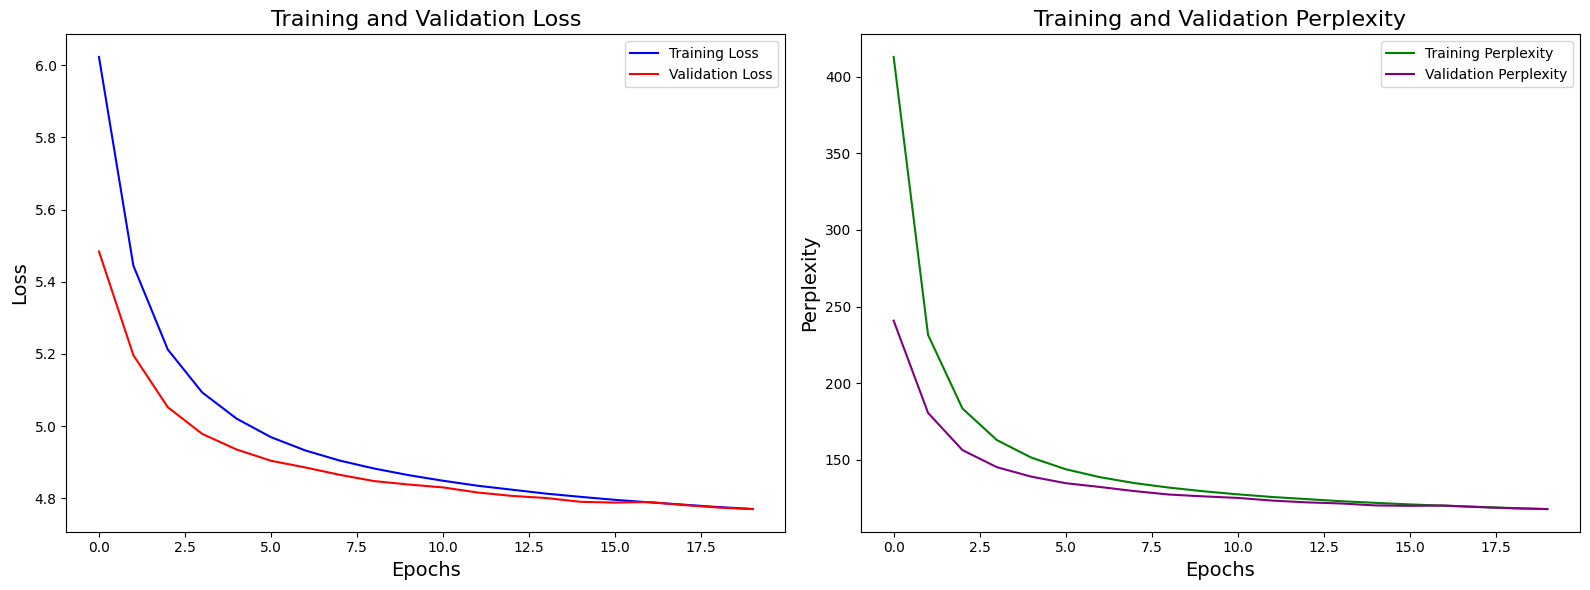

Test Perplexity: 109.590


(4.696746969223023, tensor(109.5901))

In [ ]:
params = {
    'batch_size': 2048,
    'time_step': 20,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'num_rnn_layer': 2,
    'dropout': 0.3,
    'epoch': 20,
    'learning_rate': 0.001,
    'training_shuffle': True,
    'weight_decay': 0.0001,
    'clip_value': 5
}
model = RNNModel(params).to(device)
model.train()
model.test()

**Conclusion**

Adding more RNN layers (making the network deeper) can help capture more complex features and relationships in the data due to the increased representational power. Layers=2 increases our performance and is suitable for our problem.

## 4. LSTM

By switching from RNN to LSTM, the model can potentially capture longer dependencies and mitigate issues like vanishing gradients. This could lead to improved performance, especially on tasks requiring understanding of long-term context.

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, params):
        super(LSTMModel, self).__init__()
        self.params = params

        self.train_loader, self.valid_loader, self.test_loader, self.token_to_id = load_data(self.params)
        print (len(self.train_loader), len(self.valid_loader), len(self.test_loader))

        self.embedding = nn.Embedding(len(self.token_to_id), self.params['embedding_dim'])  # random initialize
        self.h = self._init_hidden(self.params['batch_size'])
        self.rnn = nn.LSTM(self.params['embedding_dim'], self.params['hidden_dim'], self.params['num_rnn_layer'], dropout=self.params['dropout'], batch_first=True)
        self.fc = nn.Linear(self.params['hidden_dim'], len(self.token_to_id))

        self.criterion = nn.CrossEntropyLoss()
        if self.params['weight_decay']:
          self.optimizer = optim.Adam(self.parameters(), lr=self.params['learning_rate'], weight_decay=self.params['weight_decay'])
        else:
          self.optimizer = optim.Adam(self.parameters(), lr=self.params['learning_rate'])

    def _init_hidden(self, batch_size):
        # Initialize both the hidden and cell states
        return (torch.zeros(self.params['num_rnn_layer'], batch_size, self.params['hidden_dim']).to(device),
            torch.zeros(self.params['num_rnn_layer'], batch_size, self.params['hidden_dim']).to(device))

    def forward(self, x, hidden):
        x = self.embedding(x)  # The embedding layer translates these indices into dense vectors of fixed size (the embedding size).
        x, (hidden, cell) = self.rnn(x, hidden)
        x = x[:, -1, :]   # Select only the outputs from the last timestep of each sequence
        x = x.contiguous().view(-1, self.params['hidden_dim'])  # Reshape output for the fully connected layer
        out = self.fc(x)
        return out, (hidden, cell)

    def train(self):
        train_losses = []
        validation_losses = []
        train_perplexities = []
        validation_perplexities = []

        for epoch in range(self.params['epoch']):
            # Train
            train_loss = 0
            for id, (inputs, labels) in enumerate(self.train_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                self.optimizer.zero_grad()
                if self.params['training_shuffle']:
                    hidden = self._init_hidden(inputs.size(0))
                else:
                    hidden = (self.h[0].detach(), self.h[1].detach())
                outputs, self.h = self.forward(inputs, hidden)
                loss = self.criterion(outputs, labels.view(-1))
                loss.backward()
                if self.params['clip_value']:
                  torch.nn.utils.clip_grad_norm_(self.parameters(), self.params['clip_value'])
                self.optimizer.step()
                train_loss += loss.item()
            train_loss /= len(self.train_loader)
            train_losses.append(train_loss)
            train_perplexity = torch.exp(torch.tensor(train_loss)).item()
            train_perplexities.append(train_perplexity)
            print (f'Epoch {epoch + 1}/{self.params["epoch"]}, Train Loss: {train_loss:.4f}, Train Perplexity: {train_perplexity:.4f}')

            # Validation
            validation_loss = 0
            with torch.no_grad():
                for id, (inputs, labels) in enumerate(self.valid_loader):
                    inputs, labels = inputs.to(device), labels.to(device)
                    hidden = self._init_hidden(inputs.size(0))
                    outputs, _ = self.forward(inputs, hidden)
                    loss = self.criterion(outputs, labels.view(-1))
                    validation_loss += loss.item()
            validation_loss /= len(self.valid_loader)
            validation_losses.append(validation_loss)
            validation_perplexity = torch.exp(torch.tensor(validation_loss)).item()
            validation_perplexities.append(validation_perplexity)
            print (f'Epoch {epoch + 1}/{self.params["epoch"]}, Validation Loss: {validation_loss:.4f}, Validation Perplexity: {validation_perplexity:.4f}')

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        # Plotting Training and Validation Loss on the first subplot
        ax1.plot(train_losses, label='Training Loss', color='blue')
        ax1.plot(validation_losses, label='Validation Loss', color='red')
        ax1.set_title('Training and Validation Loss', fontsize=16)
        ax1.set_xlabel('Epochs', fontsize=14)
        ax1.set_ylabel('Loss', fontsize=14)
        ax1.legend()
        # Plotting Training and Validation Perplexity on the second subplot
        ax2.plot(train_perplexities, label='Training Perplexity', color='green')
        ax2.plot(validation_perplexities, label='Validation Perplexity', color='purple')
        ax2.set_title('Training and Validation Perplexity', fontsize=16)
        ax2.set_xlabel('Epochs', fontsize=14)
        ax2.set_ylabel('Perplexity', fontsize=14)
        ax2.legend()
        # Display the plots
        plt.tight_layout()
        # fig_name = '_'.join([str(item) for item in self.params.values()]) + '.jpg'
        # plt.savefig(fig_name, dpi=300, bbox_inches='tight')
        plt.show()

    def test(self):
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                hidden = self._init_hidden(inputs.size(0))
                outputs, _ = self.forward(inputs, hidden)
                loss = self.criterion(outputs, labels.view(-1))
                total_loss += loss.item()
        avg_loss = total_loss / len(self.test_loader)
        perplexity = torch.exp(torch.tensor(avg_loss))
        print(f'Test Perplexity: {perplexity.item():.3f}')
        return avg_loss, perplexity

2039 213 240
Epoch 1/20, Train Loss: 5.9622, Train Perplexity: 388.4709
Epoch 1/20, Validation Loss: 5.4364, Validation Perplexity: 229.6033
Epoch 2/20, Train Loss: 5.4203, Train Perplexity: 225.9454
Epoch 2/20, Validation Loss: 5.2045, Validation Perplexity: 182.0899
Epoch 3/20, Train Loss: 5.2629, Train Perplexity: 193.0453
Epoch 3/20, Validation Loss: 5.1231, Validation Perplexity: 167.8538
Epoch 4/20, Train Loss: 5.1936, Train Perplexity: 180.1178
Epoch 4/20, Validation Loss: 5.0748, Validation Perplexity: 159.9333
Epoch 5/20, Train Loss: 5.1453, Train Perplexity: 171.6158
Epoch 5/20, Validation Loss: 5.0388, Validation Perplexity: 154.2905
Epoch 6/20, Train Loss: 5.1083, Train Perplexity: 165.3820
Epoch 6/20, Validation Loss: 5.0184, Validation Perplexity: 151.1758
Epoch 7/20, Train Loss: 5.0810, Train Perplexity: 160.9314
Epoch 7/20, Validation Loss: 4.9906, Validation Perplexity: 147.0289
Epoch 8/20, Train Loss: 5.0583, Train Perplexity: 157.3203
Epoch 8/20, Validation Loss: 4.9

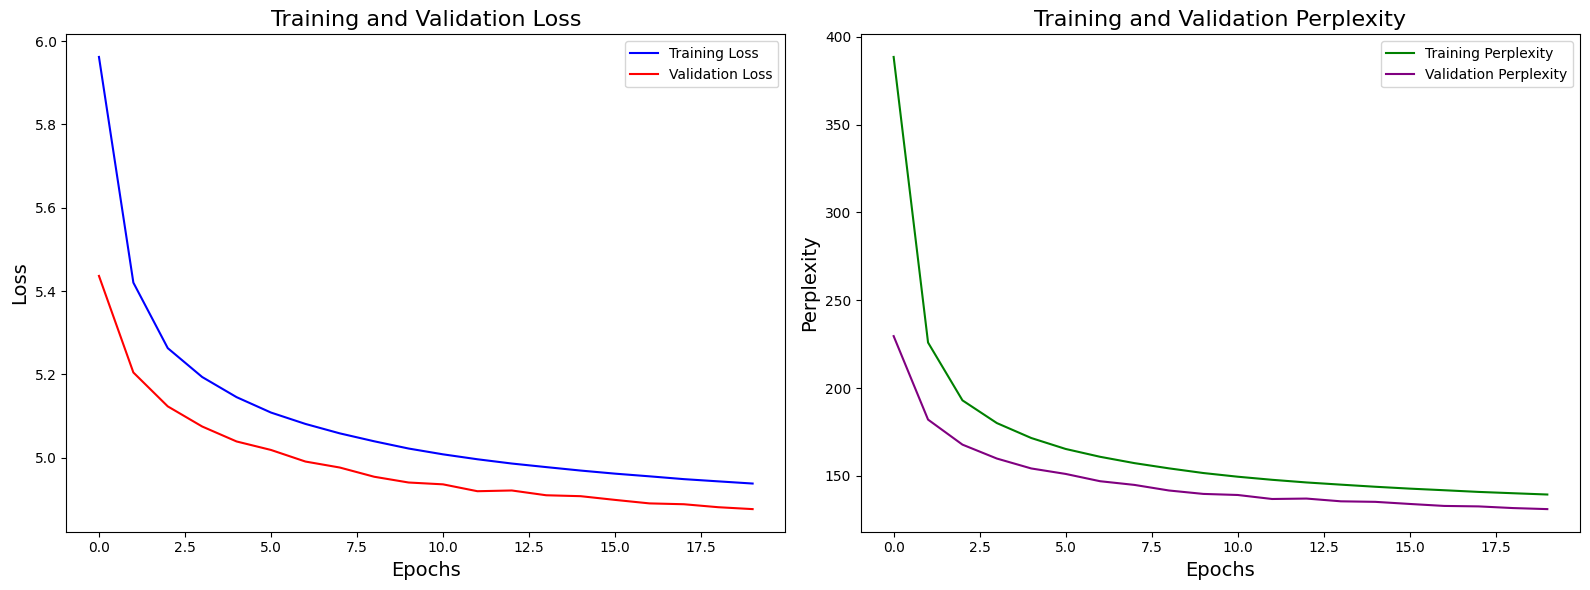

Test Perplexity: 122.452


(4.807715344429016, tensor(122.4515))

In [27]:
params = {
    'batch_size': 1024,
    'time_step': 20,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'num_rnn_layer': 2,
    'dropout': 0,
    'epoch': 20,
    'learning_rate': 0.001,
    'training_shuffle': True,
    'weight_decay': 0.0001,
    'clip_value': 5
}
model = LSTMModel(params).to(device)
model.train()
model.test()

Compared with the rnn model with the same hyper parameters, there is no significant increase in the perplexity.

The reasons might be as follows:

1. If the task is relatively simple or the sequences are short, the advantages of LSTMs may not come into play, and the simpler RNN might perform adequately or even better due to fewer parameters and less overfitting.
2. For datasets where long-term dependencies are less important, or contexts are short enough, LSTMs may not show significant improvement over RNNs.
3. LSTMs may require more epochs to converge due to their complexity. If training is halted too soon (20 epochs), the LSTM might not reach its full potential.